# VaR Computation with the Extreme Value Theory

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import numpy as np
from scipy.stats import norm
import math
import random
import time
plt.style.use('dark_background')

In [2]:
data = pd.read_csv("Natixis.txt",header = None,sep='\t',decimal = ',',parse_dates=True)
data.columns = ('Date','Price')
data['Date'] = pd.to_datetime(data['Date'],format='%d/%m/%Y')
data['Price'] = data['Price'].astype(float)

In [3]:
data1 = data[data['Date'].between("2015-01-02","2016-12-31")]

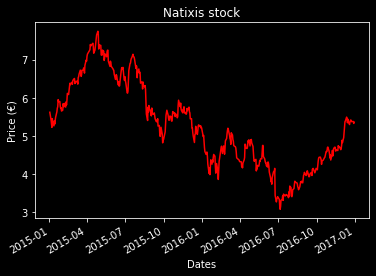

In [4]:
plt.plot(data1['Date'],data1['Price'],color = "red")
plt.title("Natixis stock")
plt.xlabel("Dates")
plt.ylabel("Price (€)")
plt.gcf().autofmt_xdate()

Computation of the historical returns

In [5]:
data['Returns'] = (data['Price'] - data['Price'].shift(1))/ data['Price'].shift(1)

In [6]:
data.head()

,Date,Price,Returns
0,2015-01-02,5.621,NaN
1,2015-01-05,5.424,-0.035047
2,2015-01-06,5.329,-0.017515
3,2015-01-07,5.224,-0.019704
4,2015-01-08,5.453,0.043836


In [7]:
V = 1000 #We set the initial value of our portfolio at $1000

We're interested in visualizing the distribution of the extreme events which correspond to the highest and the lowest returns in each block.
Using Fischer-Tippett's Theorem, we know that this normalized distribution will converge in law to a non-degenerated law cumulative distribution function G which corresponds to the GEV function of Jenkinson and von Mises with parameter $\xi$.

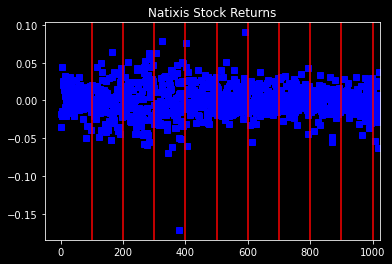

In [8]:
chunk = 100 #magnitude of the chunk used to divide the time series
plt.plot(data['Returns'],'bs')
plt.xlim(right=len(data))
plt.title("Natixis Stock Returns")
for i in range(0,len(data),chunk):
    plt.axvline(x=chunk + i,c="r")

In [9]:
def cdfGEV(x,e):
    if(e == 0):
        return np.exp(-np.exp(-x))
    else:
        if(1.0 + e * x > 0):
            return np.exp(-(1 + e * x) ** (-1 / e))
        elif(e > 0):
            return 0
        else:
            return 1

Here are some plots of the GEV cumulative distribution functions for several $\xi$.

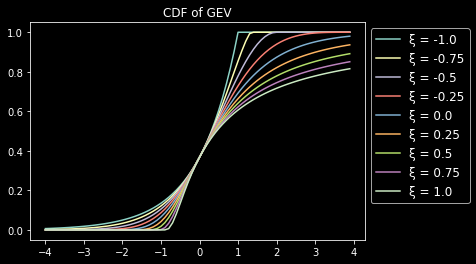

In [10]:
GEVcdf = []
x = np.arange(-4,4,0.1)
for e in np.arange(-1,1.25,0.25):
    GEVcdf.clear()
    for i in x:
        GEVcdf.append(cdfGEV(i,e))
    plt.plot(x,GEVcdf,label = "ξ = {}".format(e))
    plt.legend(loc="upper left", prop={'size': 12}, bbox_to_anchor=(1,1))
    plt.title("CDF of GEV")

We can also visualize the density function of the GEV function which corresponds to the derivative function of the cdf.

In [11]:
def pdfGEV(x,e):
    if(e == 0):
        return np.exp(-x) * np.exp(-np.exp(-x))
    elif (1 + e * x) > 0:
        return ((1 + e * x) ** ( - (e + 1) / e)) * np.exp(-(1 + e * x ) ** (-1 / e))
    else:
        return 0

Here are some plots of the GEV density distribution functions for several $\xi$.

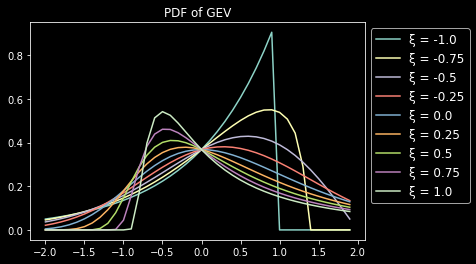

In [12]:
GEVpdf = []
x = np.arange(-2,2,0.1)
for e in np.arange(-1,1.25,0.25):
    GEVpdf.clear()
    for i in x:
        GEVpdf.append(pdfGEV(i,e))
    plt.plot(x,GEVpdf,label = "ξ = {}".format(round(e,2)))
    plt.legend(loc="upper left", prop={'size': 12}, bbox_to_anchor=(1,1))
    plt.title("PDF of GEV")

There is another way of defining extreme events. 
We can define a certain threshold and admit that the events exceeding this threshold are considered as extreme events. Therefore, we are now interested in the distribution of the returns above and below that threshold.
Using Pickands-Balkema-de Haan's theorem, we know that this distribution will converge to a generalized Pareto distribution function (GDP) with parameter $\xi$.

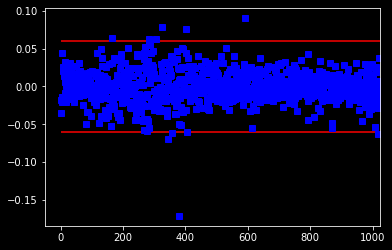

In [13]:
threshold = 0.06 #threshold beyond which we consider the returns to be extreme events
plt.plot(data['Returns'],'bs')
plt.xlim(right=len(data))
plt.hlines(threshold,xmin=0,xmax=len(data),colors="red")
plt.hlines(-threshold,xmin=0,xmax=len(data),colors="red")

In [14]:
def cdfGDP(x,e):
    if(e == 0):
        return 1 - np.exp(-x)
    elif (e >= 0 and x >= 0) or (e <= 0 and x < (- 1/e)):
        return 1 - pow((1 + e * x),(-1/e))
    else:
        return 1

Here are some plots of the GDP cumulative distribution functions for several $\xi$.

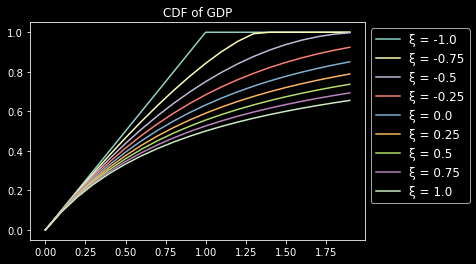

In [15]:
GDPcdf = []
x = np.arange(0,2,0.1)
for e in np.arange(-1,1.25,0.25):
    GDPcdf.clear()
    for i in x:
        GDPcdf.append(cdfGDP(i,e))
    plt.plot(x,GDPcdf,label = "ξ = {}".format(e))
    plt.legend(loc="upper left", prop={'size': 12}, bbox_to_anchor=(1,1))
    plt.title("CDF of GDP")

In [16]:
def pdfGDP(x,e):
    if(e == 0):
        return np.exp(-x)
    elif (e >= 0 and x >= 0) or (e <= 0 and x < (- 1/e)):
        return pow((1 + e * x),((-1/e) - 1))
    else:
        return 0

Here are some plots of the GDP density distribution functions for several $\xi$.

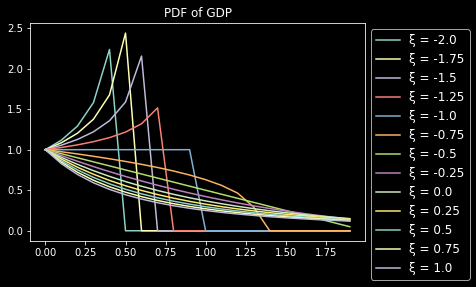

In [17]:
threshold = 1
GDPpdf = []
x = np.arange(0,2,0.1)
for e in np.arange(-2,1.25,0.25):
    GDPpdf.clear()
    for i in x:
        GDPpdf.append(pdfGDP(i/threshold,e))
    plt.plot(x,GDPpdf,label = "ξ = {}".format(round(e,2)))
    plt.legend(loc="upper left", prop={'size': 12}, bbox_to_anchor=(1,1))
    plt.title("PDF of GDP")

Our goal is to estimate the VaR of a portfolio composed of this one stock using the GEV distribution, therefore we need to estimate the $\xi$ parameter of the GEV distribution.

We can estimate it with the estimator of Hill that we can compute using the past returns of the stock.

The estimator of Hill needs a function k mapping from the integers set to the integers set such that :
$\lim_{n \to \infty} k(n) = \infty$ and
$\lim_{n \to \infty} \frac{k(n)}{n} = 0$

Several functions satisfy this criteria, we will use the logarithm function which satisfies this criteria.

In [18]:
def k_n(n):
    return int(np.log(n))

In [19]:
def Hill_estimate(X,k):
    X = sorted(X)
    n = len(X)
    logsum = 0
    for i in range(n - k + 1,n):
        logsum += np.log(X[i]/X[n - k + 1])
    return logsum / k

In [20]:
def mean(df):
    cumsum = 0
    for x in df:
        cumsum += x
    return cumsum/len(df)

In [21]:
#Standard deviation
def sd(df): 
    mu = mean(df)
    cumsum = 0
    for x in df:
        cumsum += (x - mu)**2
    return np.sqrt(cumsum / len(df))

We can now estimate ξ for both gains and losses using the estimator of Hill function.

In [22]:
e = 0
X = sorted(data['Returns'].dropna().tolist())
n = len(data)
mu = mean(X)
sigma = sd(X)
k = k_n(n)
#We center and reduce the tails data to apply Fisher-Tippett's theorem
Xpos = (sorted([(x - mu)/sigma for x in data['Returns'].dropna().tolist() if x > 0]))
Xneg = (sorted([(x - mu)/sigma for x in data['Returns'].dropna().tolist() if x < 0]))
e1 = Hill_estimate(Xpos,k)
e2 = Hill_estimate(Xneg,k)
print("The estimator of Hill for extreme gains gives us ξ : {}".format(e1))
print("The estimator of Hill for extreme losses gives us ξ : {}".format(e2))

The estimator of Hill for extreme gains gives us ξ : 0.12785712636978697
The estimator of Hill for extreme losses gives us ξ : -0.5016780163032318


We can plot the corresponding GEV and GDP density functions.

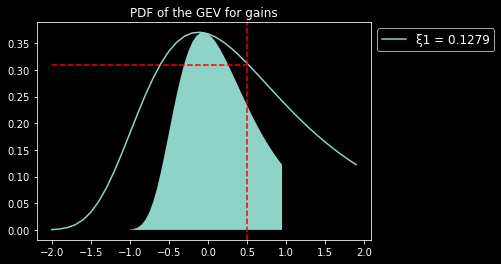

In [24]:
GEVpdf = []
x = np.arange(-2,2,0.1)
for i in x:
    GEVpdf.append(pdfGEV(i,e1))
    
plt.plot(x,GEVpdf,label = "ξ1 = {}".format(round(e1,4)))
plt.legend(loc="upper left", prop={'size': 12}, bbox_to_anchor=(1,1))
plt.title("PDF of the GEV for gains")
section = np.arange(-1, 1, 1/20.)
plt.fill_between(section,y1=0,y2=GEVpdf)
plt.axvline(0.5,c='r',linestyle='--')
plt.hlines(0.31,xmin=-2,xmax=0.5,colors='r',linestyle='--')

This represents the density distribution of the maximum returns estimated with the estimator of Hill.
We can interpret it by using an example : if a positive extreme event were to occur, there is approximately 31% chances that the stock would go up of 50%.

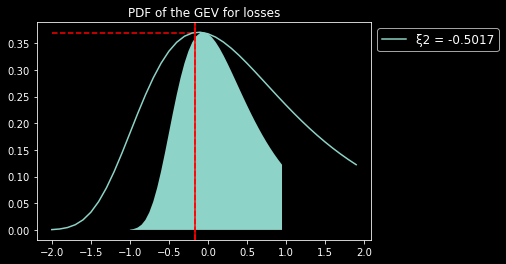

In [25]:
GEVpdf = []
x = np.arange(-2,2,0.1)
for i in x:
    GEVpdf.append(pdfGEV(i,e1))
    
plt.plot(x,GEVpdf,label = "ξ2 = {}".format(round(e2,4)))
plt.legend(loc="upper left", prop={'size': 12}, bbox_to_anchor=(1,1))
plt.title("PDF of the GEV for losses")
section = np.arange(-1, 1, 1/20.)
plt.fill_between(section,y1=0,y2=GEVpdf)
plt.axvline(-0.16,c='r')
plt.axvline(-0.16,c='r',linestyle='--')
plt.hlines(0.37,xmin=-2,xmax=-0.16,colors='r',linestyle='--')

If a negative extreme event were to occur, there is approximately 37% chances that the stock would go down of 16%.

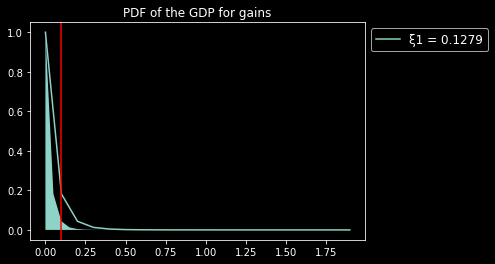

In [26]:
threshold = 0.06
GDPpdf = []
x = np.arange(0,2,0.1)
for i in x:
    GDPpdf.append(pdfGDP(i/threshold,e1))
plt.plot(x,GDPpdf,label = "ξ1 = {}".format(round(e1,4)))
plt.legend(loc="upper left", prop={'size': 12}, bbox_to_anchor=(1,1))
plt.title("PDF of the GDP for gains")
section = np.arange(0, 1, 1/20.)
plt.fill_between(section,GDPpdf)
plt.axvline(0.1,c="r")

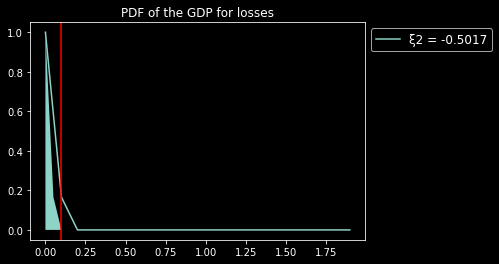

In [27]:
threshold = 0.06
GDPpdf = []
x = np.arange(0,2,0.1)
for i in x:
    GDPpdf.append(pdfGDP(i/threshold,e2))
plt.plot(x,GDPpdf,label = "ξ2 = {}".format(round(e2,4)))
plt.legend(loc="upper left", prop={'size': 12}, bbox_to_anchor=(1,1))
plt.title("PDF of the GDP for losses")
section = np.arange(0, 1, 1/20.)
plt.fill_between(section,GDPpdf)
plt.axvline(0.1,c="r")

Using the GDP distribution, we can observe that the likelihood of the events exceeding the threshold is concentrated below 10%.
That means that the probability that the returns exceeds the threshold value + 10% is very low.
Here we will have a low likelihood that daily returns > 16% or < -16% if an extreme event were to occur.

We can compute an the VaR based on the EVT distribution by using the estimator of Hill.

We will use the $\xi$ coefficient associated with the tail losses to compute the VaR.

In [28]:
def VaR_Hill(X,k,p,e):
    X = sorted(X)
    return pow((k/n*(1-p)),e) * X[n-k+1]

In [30]:
Hill_VaR = []
X = sorted(data['Returns'].dropna().tolist())
Xpos = sorted([x for x in data['Returns'].dropna().tolist() if x > 0])
Xneg = sorted([x for x in data['Returns'].dropna().tolist() if x < 0])
x = np.arange(-4,4,0.01)
n = len(data)
k = k_n(n)
for i,confidence in enumerate(np.arange(0.95,0.99,0.01)):
    Hill_VaR.append(VaR_Hill(X,k,1-confidence,e2))
    print("EVT VaR at confidence {} = {} %".format(confidence,Hill_VaR[i]*100))

EVT VaR at confidence 0.95 = 87.5094562142158 %
EVT VaR at confidence 0.96 = 87.05095506423262 %
EVT VaR at confidence 0.97 = 86.59957042926754 %
EVT VaR at confidence 0.98 = 86.15512017785416 %
EVT VaR at confidence 0.99 = 85.71742863698472 %


In [31]:
for i,confidence in enumerate(np.arange(0.95,0.99,0.01)):
    print("Our portfolio will lose less than ${} at a 1 day horizon with a probability of {}".format(V*Hill_VaR[i],confidence))

Our portfolio will lose less than $875.094562142158 at a 1 day horizon with a probability of 0.95
Our portfolio will lose less than $870.5095506423263 at a 1 day horizon with a probability of 0.96
Our portfolio will lose less than $865.9957042926754 at a 1 day horizon with a probability of 0.97
Our portfolio will lose less than $861.5512017785416 at a 1 day horizon with a probability of 0.98
Our portfolio will lose less than $857.1742863698473 at a 1 day horizon with a probability of 0.99


We calculated the Value At Risk of our portfolio using the EVT approach. 
We initially made the assumption that the returns were iid.
In practice, this is quite an unrealistic hypothesis because there is serial autocorrelation between the daily returns.
Leadbetter's theorem suggests that if two extreme events become approximately independent if they are separated by enough time.
With this approach the we put an exponent on the GEV or GDP cdf that corresponds to an extremal index that can be estimated.